In [0]:
# Standard library imports
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

# NLTK imports
from nltk.corpus import stopwords

# PySpark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    col, struct, explode, lower, regexp_extract, countDistinct, length, udf, size, mean, desc, split, collect_list ,count, sum as sum_ ,avg, rank
)
from pyspark.sql.types import (
    StructType, StructField, StringType, ArrayType, FloatType, BooleanType, IntegerType
)
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, when, split, row_number,dense_rank, regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import udf, percentile_approx
from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt



# Question 1

## Table A

In [0]:
spark = SparkSession.builder.getOrCreate()

english_stopwords = stopwords.words('english')
stopwords_string = ' '.join(english_stopwords)
stopWords = set(stopwords_string.split())

profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

In [0]:
df = profiles.withColumnRenamed("id", "user_id").withColumnRenamed("name", "user_name")
df = df.withColumn("current_company_id", col("current_company.company_id")) \
       .withColumn("current_company_name", col("current_company.name")) \
       .withColumn("current_position", col("current_company.title"))

df_with_experience_count = df.withColumn("experience_count", size("experience"))

top_10_people = df_with_experience_count.orderBy(col("experience_count").desc()).limit(10)

exploded_df = top_10_people.select("user_id", explode("experience").alias("experience"))

filtered_df = exploded_df.filter(
    (col("experience.subtitle").isNotNull()) & 
    (col("experience.subtitle") != "") & 
    (col("experience.subtitle") != "N/A")
)

distinct_company_count = filtered_df.groupBy("user_id").agg(
    countDistinct("experience.subtitle").alias("distinct_companies_count")
)

final_result = top_10_people.join(
    distinct_company_count, 
    on=["user_id"], 
    how="inner"
).select(
    "user_id", 
    "user_name", 
    "current_company_id",
    "current_company_name",
    "current_position",
    "distinct_companies_count",
    #"experience_count"
)
display(final_result)

user_id,user_name,current_company_id,current_company_name,current_position,distinct_companies_count
cheretheriot,Chere Theriot,null,"Film, Television, Commercial, Print","Set Decoration, Art Direction, Production Design, Props",77
amelia-ferroni-09b02310,Amelia Ferroni,null,Self-employed,Freelance - Script Supervisor,69
jessicafeiyali,Jessica Li,beacons-ai,Beacons,Chief of Staff at Beacons (YC S19) | Harvard Alum,90
brettcarlson4,Brett Carlson,null,null,Commercial Line Producer and Production Manager,53
jchengvc,J C.,gen1capital,Gen 1 Capital,"Venture Capital Investor, Entrepreneur",83
derekmccants,"Derek McCants, ACE",null,American Cinema Editors,null,75
allyn-nielsen-4755666a,Allyn Nielsen,null,self,retired at self,1
aliciagood,Alicia Good,pitman-casting,PITMAN CASTING,Casting Director at Damn Good Casting,58
patriciafarrell,Patricia Farrell,null,Billy Graham Rapid Response Team,Member at John Maxwell Team,48
jyoti-singh-171172a,Jyoti Singh,null,RVP Productions,Zindagi Hain,69


## Table B

In [0]:
companies_df = companies

selected_companies_df = companies_df.select(
    col("company_size").alias("current_company_size"),
    col("company_id").alias("current_company_id"),
    col("name").alias("current_company_name"),
    col("id").alias("comp_id")
)

df = profiles.select("id","name","education","current_company.company_id","experience")
df=df.filter(F.col("company_id").isNotNull())


df = df.withColumn(
    "education",
    expr("filter(education, edu -> edu.start_year is not null and edu.end_year is not null)")
)

df = df.withColumn(
    "years_of_education",
    F.expr("TRANSFORM(education, e -> CAST(e.end_year AS INT) - CAST(e.start_year AS INT))")
)

df = df.withColumn("total_years_education", F.expr("AGGREGATE(years_of_education, 0, (acc, x) -> acc + x)"))
df = df.select("id","name","education","company_id","total_years_education",explode("experience").alias("exp"))
df = df.withColumn("duration_short_array", split("exp.duration_short", ","))
df = df.select("id","name","company_id","total_years_education","exp","education",explode("duration_short_array").alias("exp_duration"))
df = df.filter(
    col("exp_duration").isNotNull() & (col("exp_duration") != "")
)

df = df.withColumn(
    "start_date",
    expr("""
    CASE 
        WHEN exp.start_date RLIKE '[a-zA-Z]' THEN exp.start_date
        ELSE concat('Jan ', exp.start_date)
    END
    """)
)

df = df.withColumn(
    "position_index",
    row_number().over(Window.partitionBy("id").orderBy(expr("to_date(start_date, 'MMM yyyy')")))
)

df = df.withColumn(
    "company_index",
    F.expr("-1 * (row_number() OVER (PARTITION BY id ORDER BY to_date(start_date, 'MMM yyyy') DESC) - 1)")
)

df = df.withColumn(
    "company_months",
    when(col("exp_duration").isNull(), 0)
    .when(col("exp_duration").contains("year"),
          expr("""
          CASE 
            WHEN exp_duration = 'less than a year' THEN 6 
            WHEN exp_duration LIKE '% year%' AND exp_duration LIKE '% month%' THEN 
              CAST(SUBSTRING_INDEX(exp_duration, ' year', 1) AS INT) * 12 
              + CAST(SUBSTRING_INDEX(SUBSTRING_INDEX(exp_duration, ' ', -2), ' ', 1) AS INT)
            WHEN exp_duration LIKE '% year%' THEN 
              CAST(SUBSTRING_INDEX(exp_duration, ' year', 1) AS INT) * 12 
            END
          """))
    .otherwise(expr("IFNULL(CAST(SUBSTRING_INDEX(SUBSTRING_INDEX(exp_duration, ' month', 1), ' ', 1) AS INT), 0)"))
)
 
result_PartB_df=df.select(
    col("id").alias("user_id"),
    col("name").alias("user_name"),
    col('total_years_education'),
    col('company_id').alias("comp_id"),
    col('exp.subtitle').alias("company_subtitle"),
    col('exp.title').alias("company_title"),
    col("company_months"),
    col("company_index")

)

final_join=result_PartB_df.join(selected_companies_df,on="comp_id",how="inner")
windowSpec = Window.orderBy(col("total_years_education").desc())
final_join = final_join.withColumn("rank", dense_rank().over(windowSpec))
final_join = final_join.filter(col("rank") <= 10)
final_join = final_join.drop("rank")
final_join = final_join.dropDuplicates(["user_id", "company_index"])
final_join=final_join.orderBy(col("total_years_education").desc(),col("company_index").desc())
final_join = final_join.drop("comp_id")
final_join=final_join.select("user_id","user_name","total_years_education","current_company_id","current_company_name","current_company_size","company_subtitle","company_title","company_months","company_index")
final_join.display()

user_id,user_name,total_years_education,current_company_id,current_company_name,current_company_size,company_subtitle,company_title,company_months,company_index
susanjohnsonbas,Susan Johnson,70,6744378,Ohio Auctioneers Assn,2-10 employees,Ohio Auctioneers Assn,President,9,0
susanjohnsonbas,Susan Johnson,70,6744378,Ohio Auctioneers Assn,2-10 employees,Ohio Auctioneers Association,Vice President,33,-1
susanjohnsonbas,Susan Johnson,70,6744378,Ohio Auctioneers Assn,2-10 employees,Johnson Auctioneer's,"Co-Owner, Principle Auctioneer & Realtor",192,-2
susanjohnsonbas,Susan Johnson,70,6744378,Ohio Auctioneers Assn,2-10 employees,Susan's Auction Service,"Owner, Principle Auctioneer, Consultant",297,-3
jay-levander-978a208b,Jay Levander,69,5556,U.S. Department of Energy (DOE),"10,001+ employees",U.S. Department of Energy,Chemical engineering technician,549,0
jay-levander-978a208b,Jay Levander,69,5556,U.S. Department of Energy (DOE),"10,001+ employees",Department of Energy,Chemical engineering technician,549,-1
bruce-carter-b8031440,Bruce Carter,65,165404,Pasadena City College,"1,001-5,000 employees",Pasadena City College,"Dean, Retired, Professor emeritus",214,0
bruce-carter-b8031440,Bruce Carter,65,165404,Pasadena City College,"1,001-5,000 employees",USC,Geology Instructor,12,-1
troy-savage-9675b1b4,Troy Savage,58,108855,"Wetland Studies and Solutions, Inc. (WSSI), a Davey Tree Company",201-500 employees,"Wetland Studies and Solutions, Inc. (WSSI), a Davey Tree Company",Senior Associate Consultant V,72,0
troy-savage-9675b1b4,Troy Savage,58,108855,"Wetland Studies and Solutions, Inc. (WSSI), a Davey Tree Company",201-500 employees,Kerr Environmental Services Corp.,Senior Environmental Scientist,28,-1


# Question 2

## Query 1

In [0]:
query_A = """SELECT
    distinct_users.user_name,
    distinct_users.recommendations_count,
    p.experience[0].duration_short as duration_short,
    CASE 
        WHEN p.experience[0].duration_short LIKE '%year%' THEN 
            (CAST(SPLIT(p.experience[0].duration_short, ' ')[0] AS INT) * 12) + 
            (CASE 
                WHEN p.experience[0].duration_short LIKE '%month%' THEN 
                    CAST(SPLIT(p.experience[0].duration_short, ' ')[2] AS INT)
                ELSE 0 
            END)
        WHEN p.experience[0].duration_short LIKE '%month%' THEN 
            CAST(SPLIT(p.experience[0].duration_short, ' ')[0] AS INT)
        WHEN p.experience[0].duration_short LIKE '%less than a year%' THEN 6
    END as experience_company_month
FROM
    (SELECT
         name as user_name,
         recommendations_count,
         ROW_NUMBER() OVER (ORDER BY recommendations_count DESC) as rn
     FROM linkedin_people
     WHERE recommendations_count IS NOT NULL
     AND size(experience) > 0) distinct_users
JOIN
    linkedin_people p ON distinct_users.user_name = p.name
WHERE
    distinct_users.rn <= 10 AND p.experience[0].duration_short IS NOT NULL 
ORDER BY
    distinct_users.recommendations_count DESC
"""

## Query 2

In [0]:
query_B = """WITH ExplodedTable AS (
    SELECT DISTINCT EXPLODE(b.people_also_viewed.profile_link) AS full_url
    FROM linkedin_people b
    WHERE b.people_also_viewed IS NOT NULL
),
DistinctProfiles AS (
    SELECT DISTINCT full_url
    FROM ExplodedTable
),
TrimmedTable AS (
    SELECT DISTINCT SUBSTRING_INDEX(full_url, '?', 1) AS trimmed_url
    FROM DistinctProfiles
),
ProfileMatches AS (
    SELECT DISTINCT trimmed_url AS people_also_viewed
    FROM linkedin_people LP
    LEFT JOIN TrimmedTable ON LP.url = TrimmedTable.trimmed_url
    WHERE TrimmedTable.trimmed_url IS NOT NULL
),

TotalProfiles AS (
    SELECT COUNT(DISTINCT url) AS total_profiles
    FROM linkedin_people
)
SELECT count(DISTINCT PM.people_also_viewed) AS people_also_viewed_count,
((SELECT COUNT(people_also_viewed) FROM ProfileMatches) / (SELECT total_profiles FROM TotalProfiles)) AS people_also_viewed_percentage
FROM ProfileMatches PM
 """

# Question 3

## Part 1

#### Most common words used in 'About' and "posts" section by people and by companies:

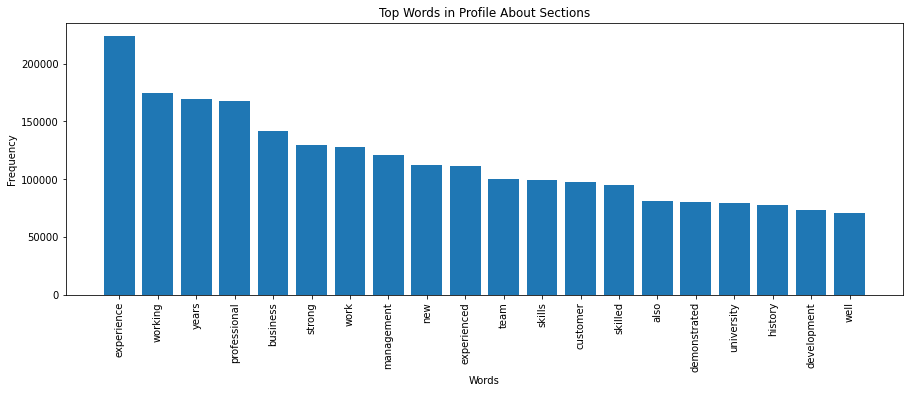

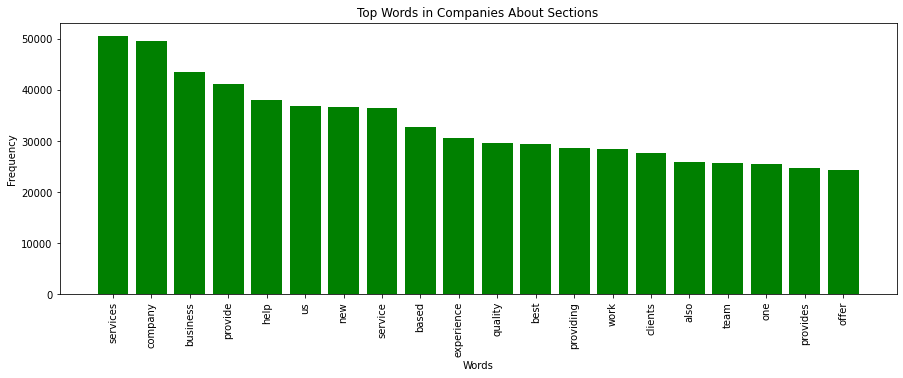

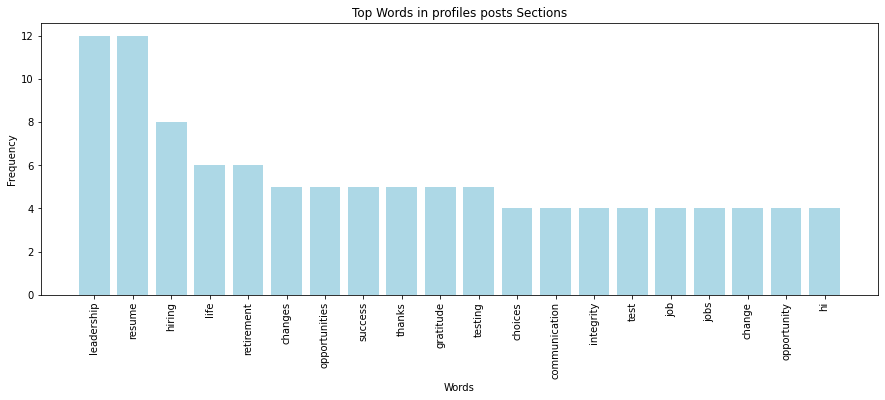

In [0]:
def clean_text(text):
    if text is not None:
        stop_words = stopWords
        words = text.lower().split()
        return list(set(word for word in words if word.isalpha() and word not in stop_words))
    else:
        return []

clean_text_udf = udf(clean_text, ArrayType(StringType()))
profiles_cleaned = profiles.withColumn("cleaned_about", clean_text_udf(col("about")))
word_counts = profiles_cleaned.select(explode(col("cleaned_about")).alias("word")).groupBy("word").count()
word_counts_list = word_counts.collect()
profile_word_counts = Counter({row['word']: row['count'] for row in word_counts_list})
top_N = 20
most_common_words = profile_word_counts.most_common(top_N)
words, counts = zip(*most_common_words)

plt.figure(figsize=(15, 5))
plt.bar(words, counts)
plt.xlabel('Words')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top Words in Profile About Sections')
plt.show()
clean_text_udf = udf(clean_text, ArrayType(StringType()))

companies_cleaned = companies.withColumn("cleaned_about", clean_text_udf(col("about")))
word_counts = companies_cleaned.select(explode(col("cleaned_about")).alias("word")).groupBy("word").count()
word_counts_list = word_counts.collect()
companies_word_counts = Counter({row['word']: row['count'] for row in word_counts_list})
top_N = 20
most_common_words = companies_word_counts.most_common(top_N)
words, counts = zip(*most_common_words)

plt.figure(figsize=(15, 5))
plt.bar(words, counts, color = "green")
plt.xlabel('Words')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top Words in Companies About Sections')
plt.show()

def clean_text2(text):
    if text is not None:
        stop_words = stopWords
        if isinstance(text, list):
            words = [word for sublist in text for word in sublist]
        else:
            words = text.split()
        words = [word.lower() for word in words if word.isalpha()]
        return [word for word in words if word not in stop_words]
    else:
        return []

clean_text_udf = udf(clean_text2, ArrayType(StringType()))
posts1 = profiles.withColumn("cleaned_about", clean_text_udf(col("posts")))
word_counts = posts1.select(explode(col("cleaned_about")).alias("word")).groupBy("word").count()
word_counts_list = word_counts.collect()
profile_word_counts = Counter({row['word']: row['count'] for row in word_counts_list})
top_N = 20
most_common_words = profile_word_counts.most_common(top_N)
words, counts = zip(*most_common_words)

plt.figure(figsize=(15, 5))
plt.bar(words, counts, color = "lightblue")
plt.xlabel('Words')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top Words in profiles posts Sections')
plt.show()

 - Individuals tend to highlight their professional experience, skill set, and work ethic.
 - The term "new" appears notably among the most frequent in the first two histograms, which might indicate a focus on new experiences or opportunities
 - Both individual profiles and company sections share a common language of advancement and development so words like "new," "team," and "work" indicate a shared emphasis on progress and collaboration.

 Overall, these histograms reveal that both individuals and companies use specific keywords to project desired professional images, with individuals focusing more on personal achievements and growth, while companies emphasize their offerings and customer service.

#### The top 5 most used words in 'about' section per 'Sphere': 

In [0]:
def clean_text(text_list):
    cleaned_list = []
    for text in text_list:
        if text is not None:
            stop_words = stopWords
            words = text.lower().split()
            cleaned_list.extend([word for word in words if word.isalpha() and word not in stop_words])
    return cleaned_list

clean_text_udf = udf(clean_text, ArrayType(StringType()))
sphere_abouts = companies.groupBy("sphere").agg(collect_list("about").alias("about_texts"))
companies_cleaned = sphere_abouts.withColumn("cleaned_about", clean_text_udf(col("about_texts")))
exploded_words = companies_cleaned.select("sphere", explode(col("cleaned_about")).alias("word"))
word_counts_per_sphere = exploded_words.groupBy("sphere", "word").count()
spheres = word_counts_per_sphere.select("sphere").distinct().collect()

schema = StructType([
    StructField("sphere", StringType(), True),
    StructField("top_word_1", StringType(), True),
    StructField("top_word_2", StringType(), True),
    StructField("top_word_3", StringType(), True),
    StructField("top_word_4", StringType(), True),
    StructField("top_word_5", StringType(), True)
])

rows = []

for sphere in spheres:
    sphere_name = sphere["sphere"]
    top_words = word_counts_per_sphere.filter(col("sphere") == sphere_name).orderBy(col("count").desc()).limit(5).collect()
    words = [word['word'] for word in top_words] + [None] * (5 - len(top_words))
    row = (sphere_name, *words)
    rows.append(row)

df = spark.createDataFrame(rows, schema)
df.show()

+--------------------+----------+------------+----------+----------+-------------+
|              sphere|top_word_1|  top_word_2|top_word_3|top_word_4|   top_word_5|
+--------------------+----------+------------+----------+----------+-------------+
|  Investment Banking|investment|   financial|   capital|  business|     services|
|Furniture and Hom...| furniture|        home|    design|    office|      quality|
|Architecture and ...|    design|architecture|      firm|   project|architectural|
|           Wholesale|  products|     quality|   company| wholesale|           us|
| Travel Arrangements|    travel|    vacation|experience|     tours|         best|
|            Ranching|       dog|         pet|  training|      care|     grooming|
|Hospitals and Hea...|      care|      health|   medical|  services|   healthcare|
|Book and Periodic...|publishing|    business|      book|       new|     magazine|
|   Printing Services|  printing|    business|     print|    custom|      quality|
|Pro

Interesting insights : 
- Each industry sphere has a distinct set of top words that are highly relevant and specific to the field.
- Across various sectors, there are common business-related terms like "business," "services," "products," and "quality."
- Certain terms may reflect cultural or regional influences on industry sectors. For example, "ranching" includes terms like "dog," "pet," "training," and "grooming,"
- These insights reflect how LinkedIn profiles within each industry sector tend to use a common set of keywords that are indicative of their professional focus

#### How many users used the word "business" in their 'about' section per each state:

In [0]:
profiles = profiles.withColumn("state", regexp_extract(col("city"), r",\s*([A-Za-z ]+),\s*United States", 1))
profiles = profiles.filter(length(col("state")) > 0)
profiles = profiles.filter(col("state") != "District of Columbia")
profiles = profiles.withColumn("mentions_business", lower(col("about")).contains("business"))
business_mentions_per_state = profiles.filter(col("mentions_business")) \
                                      .groupBy("state") \
                                      .agg(countDistinct("url").alias("unique_business_mentions"))

business_mentions_per_state.collect()
df = business_mentions_per_state.toPandas()

state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

df['state'] = df['state'].map(state_abbreviations)

fig = px.choropleth(df, 
                    locations='state', 
                    locationmode="USA-states", 
                    color='unique_business_mentions',
                    color_continuous_scale='Reds',
                    scope="usa",
                    title='Business Mentions by State')

fig.show()

And we can clearly see that users in states like California, Texas, New York and Florida use this word very often ,and that really mirrors the presence of numerous major business corporations in these regions.

#### Most common words used in 'About' and "posts" section per different years interval by people

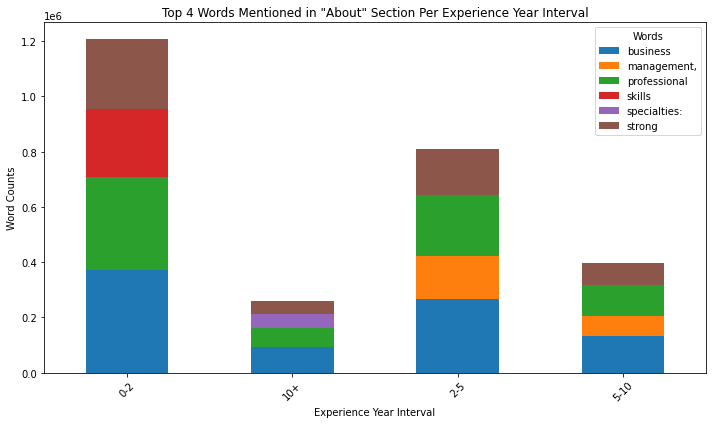

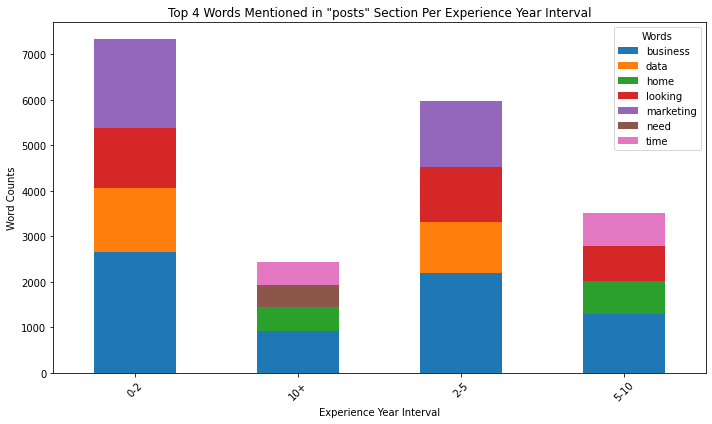

In [0]:
################################################ COMMON WORDS IN ABOUT
stop_words = set([
        "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", 
        "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
        "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", 
        "each", "few", "for", "from", "further", 
        "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", 
        "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", 
        "let's", "me", "more", "most", "mustn't", "my", "myself", 
        "no", "nor", "not", 
        "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", 
        "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such", 
        "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", 
        "this", "those", "through", "to", "too", 
        "under", "until", "up", 
        "very", 
        "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", 
        "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "experience", "working", "years", "work", "new", "management", "customer", ".", ",", "!", "?", ";", ":", "'", "\"", "-", "—", "(", ")", "[", "]", "{", "}", "...", '``', "''", "`", "~", "@", "#", 
        "$", "%", "^", "&", "*", "_", "=", "+", "/", "\\", "|", "<", ">", "•", "°", "’", "“", "”", "can", "5" ])

def convert_duration_to_decimal(duration_str):
    try:
        if duration_str is None:
            return None
        parts = duration_str.split()
        years = 0
        months = 0
        if 'years' in duration_str or 'year' in duration_str:
            years = int(parts[0])
        if 'months' in duration_str or 'month' in duration_str:
            months_index = 2 if 'years' in duration_str or 'year' in duration_str else 0
            months = int(parts[months_index])
        return years + months / 12.0
    except ValueError:
        print(f"Cannot convert {duration_str} to decimal.")
        return None  

def categorize_exp_years(exp_year):
    if exp_year is None:
        return 'Unknown'  
    elif exp_year < 2:
        return '0-2'
    elif exp_year < 5:
        return '2-5'
    elif exp_year < 10:
        return '5-10'
    else:
        return '10+'

convert_duration_to_decimal_udf = udf(convert_duration_to_decimal, FloatType())
exploded_df = profiles.selectExpr("*", "explode(experience) as exp_flat")


exploded_df = exploded_df.withColumn("exp_years", convert_duration_to_decimal_udf("exp_flat.duration_short"))
words_df = exploded_df.select('exp_years', explode(split(lower(col('about')), '\s+')).alias('word'))
is_stop_word = udf(lambda word: word in stop_words, BooleanType())
filtered_words_df = words_df.filter(is_stop_word(words_df.word))
non_stop_words_df = words_df.filter(~is_stop_word(words_df.word))

exp_years_udf = udf(categorize_exp_years, StringType())

categorized_df = non_stop_words_df.withColumn("exp_years_category", exp_years_udf("exp_years"))

final_filtered_df = categorized_df.filter(col("exp_years_category") != "Unknown")


word_counts_df = final_filtered_df.groupBy("exp_years_category", "word").count()
windowSpec = Window.partitionBy('exp_years_category').orderBy(col('count').desc())
ranked_words_df = word_counts_df.withColumn('rank', rank().over(windowSpec))


top_words_df = ranked_words_df.filter(col('rank') <= 4)
top_words_pandas_df = top_words_df.toPandas()


pivot_df = top_words_pandas_df.pivot(index='exp_years_category', columns='word', values='count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Top 4 Words Mentioned in "About" Section Per Experience Year Interval')
plt.xlabel('Experience Year Interval')
plt.ylabel('Word Counts')
plt.xticks(rotation=45)
plt.legend(title='Words')
plt.tight_layout()
plt.show()


posts_exploded_df = exploded_df.withColumn("post", explode("posts"))

words_df = posts_exploded_df.select(
    'exp_years',
    explode(split(lower(col('post.title')), '\s+')).alias('word')
)

is_stop_word = udf(lambda word: word in stop_words, BooleanType())

filtered_words_df = words_df.filter(is_stop_word(words_df.word))

non_stop_words_df = words_df.filter(~is_stop_word(words_df.word))

exp_years_udf = udf(categorize_exp_years, StringType())

categorized_df = non_stop_words_df.withColumn("exp_years_category", exp_years_udf("exp_years"))

final_filtered_df = categorized_df.filter(col("exp_years_category") != "Unknown")

word_counts_df = final_filtered_df.groupBy("exp_years_category", "word").count()

windowSpec = Window.partitionBy('exp_years_category').orderBy(col('count').desc())

ranked_words_df = word_counts_df.withColumn('rank', rank().over(windowSpec))

top_words_df = ranked_words_df.filter(col('rank') <= 4)
top_words_pandas_df = top_words_df.toPandas()


pivot_df = top_words_pandas_df.pivot(index='exp_years_category', columns='word', values='count').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Top 4 Words Mentioned in "posts" Section Per Experience Year Interval')
plt.xlabel('Experience Year Interval')
plt.ylabel('Word Counts')
plt.xticks(rotation=45)
plt.legend(title='Words')
plt.tight_layout()
plt.show()


interesting insights:
 - these histograms reflect the professional branding and engagement strategy of LinkedIn users. The "About" section is used for consistent self-promotion across career stages, while the "Posts" section is more reflective of current events, personal interests, and possibly changes as users progress in their careers.
 - in the "About" section, the usage of terms does not significantly change with experience, suggesting that professionals at all stages value similar traits or skills when presenting themselves.
 - In contrast, the "Posts" section shows variation in word counts across different experience year intervals, which might indicate that the content or topics that professionals engage with evolve as they gain more experience.

<h3>Most common words used in 'About' section per different founded years interval for companies</h2>

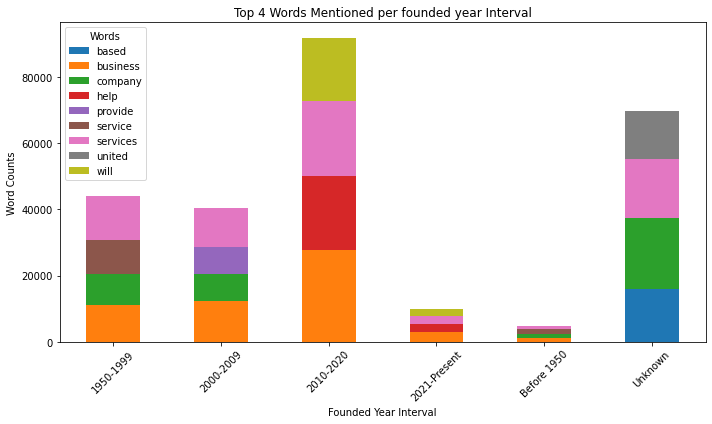

In [0]:
def categorize_founded_year(year):
    if year is None or year < 1900: 
        return 'Unknown'
    elif year < 1950:
        return 'Before 1950'
    elif year < 2000:
        return '1950-1999'
    elif year < 2010:
        return '2000-2009'
    elif year <= 2020:
        return '2010-2020'
    else:
        return '2021-Present'

categorize_founded_year_udf = udf(categorize_founded_year, StringType())
companies_with_founded_category = companies.withColumn("founded_category", categorize_founded_year_udf("founded"))

words_df = companies_with_founded_category.select('founded_category', explode(split(lower(col('about')), '\s+')).alias('word')).filter(~is_stop_word(col('word')))

word_counts_df = words_df.groupBy("founded_category", "word").count()

windowSpec = Window.partitionBy('founded_category').orderBy(col('count').desc())

ranked_words_df = word_counts_df.withColumn('rank', rank().over(windowSpec))
top_words_df = ranked_words_df.filter(col('rank') <= 4)
top_words_pandas_df = top_words_df.toPandas()

pivot_df = top_words_pandas_df.pivot(index='founded_category', columns='word', values='count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Top 4 Words Mentioned per founded year Interval')
plt.xlabel('Founded Year Interval')
plt.ylabel('Word Counts')
plt.xticks(rotation=45)
plt.legend(title='Words')
plt.tight_layout()
plt.show()

interesting insights :
- Service-Oriented Language: Words like "service" and "services" suggest that profiles often emphasize the service aspect of their business, which may imply a customer-oriented approach prevalent across various company ages.
- Modern vs. Traditional: Comparing the intervals "2010-2020" and "2021-present" with "Before 1950," we can see a shift from traditional terms like "united" to more dynamic and contemporary language, potentially indicating a shift in corporate culture and branding over time.
- Consistent Business Focus: Across all time intervals, "business" is a prominent term. This indicates a consistent focus on business-related language on LinkedIn, regardless of the age of the company.

## Part 2

In [0]:
FAANG_names = ["Apple", "Amazon Web Services (AWS)", "Amazon", "Google", "Facebook", "Netflix"]

BIG_names = ["Apple", "Amazon Web Services (AWS)", "Amazon", "Google", "Facebook", "Netflix" , "Disney Institue" , "Nasa - National Aeronautics and Space Administration", "Microsoft Community" , "Publix Pharmacy"]

users_in_big_FAANG = profiles.filter(
    col("current_company.name").isin(BIG_names)
)
users_in_big_FAANG = profiles.filter(
    col("current_company.name").isin(FAANG_names)
)
users_not_in_big_FAANG = profiles.filter(
    ~col("current_company.name").isin(FAANG_names)
)

avg_followers_by_company = users_in_big_FAANG.groupBy("current_company.name") \
                                             .agg(mean("followers").alias("average_followers"))
avg_followers_by_companyNot = users_not_in_big_FAANG.groupBy("current_company.name") \
                                                  .agg(mean("followers").alias("average_followers"))
avg_followers_by_company_orderedNot = avg_followers_by_companyNot.orderBy(desc("average_followers"))

avg_followers_by_company_orderedNot.show(10)
avg_followers_by_company.show()


+--------------------+-----------------+
|                name|average_followers|
+--------------------+-----------------+
|       Science House|         586000.0|
|Trilantic North A...|         283000.0|
|Keynote Speaker, ...|         268000.0|
|YAP - Young and P...|         227000.0|
|Brian Tracy Inter...|         216000.0|
|    Inequality Media|         170000.0|
|Lockwood Resource...|         122000.0|
|          Simplified|         105000.0|
|Homology Medicine...|          80122.0|
|          SupplyPike|          80096.8|
+--------------------+-----------------+
only showing top 10 rows

+--------------------+-----------------+
|                name|average_followers|
+--------------------+-----------------+
|Amazon Web Servic...| 889.693668528864|
|              Google| 859.312040700961|
|               Apple|544.0030807147258|
|             Netflix|931.0955056179776|
|              Amazon|527.0567524960588|
|            Facebook|472.1737089201878|
+--------------------+---------

We can see that big companies relatively has low followers count compared to many companies, also the purposes for most of these companies with high followers count tend to be for Empowerment and promotion.

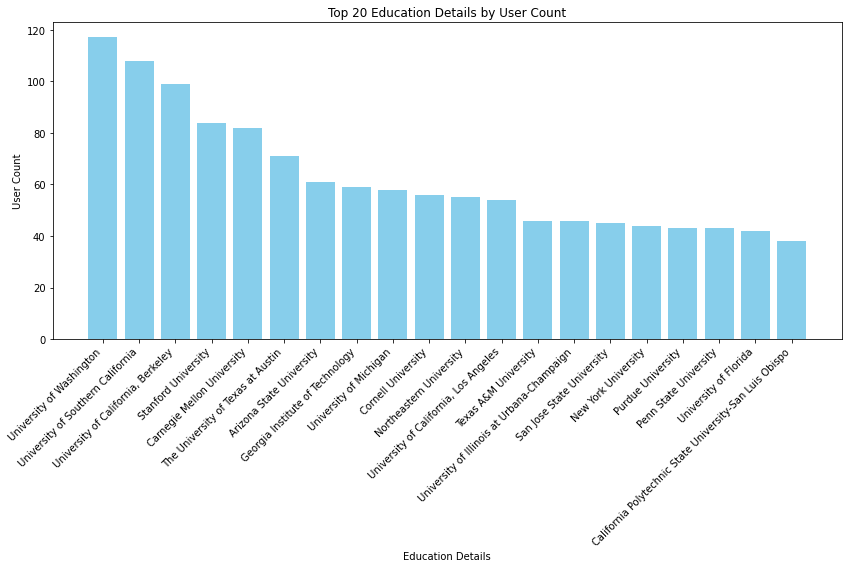

In [0]:
non_null_education_profiles = users_in_big_FAANG.filter(col("educations_details").isNotNull())
education_group_count = non_null_education_profiles.groupBy("educations_details").agg(count("*").alias("user_count"))
education_group_count_ordered = education_group_count.orderBy(col("user_count").desc())
top_20_data = education_group_count_ordered.limit(20).collect()
education_details_top_20 = [row['educations_details'] for row in top_20_data]
user_counts_top_20 = [row['user_count'] for row in top_20_data]

plt.figure(figsize=(12, 8))
plt.bar(education_details_top_20, user_counts_top_20, color='skyblue')
plt.xlabel('Education Details')
plt.ylabel('User Count')
plt.xticks(rotation=45, ha="right")
plt.title('Top 20 Education Details by User Count')
plt.tight_layout()
plt.show()

We can see that people who work in FAANG companies tend to graduate from similar prominent universities.

In [0]:
users_in_big_FAANG = profiles.filter(
    col("current_company.name").isin(FAANG_names)
)
users_not_in_big_FAANG = profiles.filter(
    ~col("current_company.name").isin(FAANG_names)
)

avg_about_length_by_company = users_in_big_FAANG.groupBy("current_company.name") \
                                                .agg(mean(length(col("about"))).alias("average_about_length"))
avg_about_length_by_companyNot = users_not_in_big_FAANG.groupBy("current_company.name") \
                                                        .agg(mean(length(col("about"))).alias("average_about_length"))
avg_about_length_by_company_orderedNot = avg_about_length_by_companyNot.orderBy(desc("average_about_length"))

avg_about_length_by_company_orderedNot.show()
overall_mean_not_in_FAANG = avg_about_length_by_company_orderedNot.agg(
    mean("average_about_length").alias("overall_average_about_length")
)

# Show the result
overall_mean_not_in_FAANG.show(10)
avg_about_length_by_company.show()


+--------------------+--------------------+
|                name|average_about_length|
+--------------------+--------------------+
|Diesel Leasing an...|              2599.0|
| Community Legal Aid|              2599.0|
|TogetherWeTri Tri...|              2599.0|
|FitnessCommunity.com|              2599.0|
|Legend Capital Co...|              2599.0|
|     Wager's Follies|              2598.0|
|Unity and Diversi...|              2598.0|
|Linn-Benton Commu...|              2598.0|
|    Order From Chaos|              2597.0|
|Four Seasons Emba...|              2597.0|
|            Rosewell|              2597.0|
|Harmony School of...|              2597.0|
|3 Dimensional Phy...|              2597.0|
|Locked My Keys In...|              2597.0|
|    Autism Navigator|              2596.0|
|Advanced NDT and ...|              2596.0|
|The Dreamers Guil...|              2596.0|
|MaldonadoBikeTech...|              2596.0|
|Artist-www.artoft...|              2596.0|
|Southeast Louisia...|          

We can see that people working in FAANG companies tend to have average 'about' section which can tell us a lot about their proffesional identity.

In [0]:
avg_num_of_courses_by_company = users_in_big_FAANG.groupBy("current_company.name") \
                                                .agg(mean(size(col("сourses"))).alias("average_num_of_courses"))

avg_num_of_courses_by_company.show()

+--------------------+----------------------+
|                name|average_num_of_courses|
+--------------------+----------------------+
|Amazon Web Servic...|    1.9301675977653632|
|              Google|    1.7066139061616732|
|               Apple|     1.476278496611214|
|             Netflix|    0.3258426966292135|
|              Amazon|    1.3271150814503416|
|            Facebook|    1.5352112676056338|
+--------------------+----------------------+



We can see that those employees tend to have similar average of number of courses taken.

<h3>Comparative Analysis of Top 10 Fields of Study Among Master's Degree Holders in FAANG vs Non-FAANG Companies<h3>

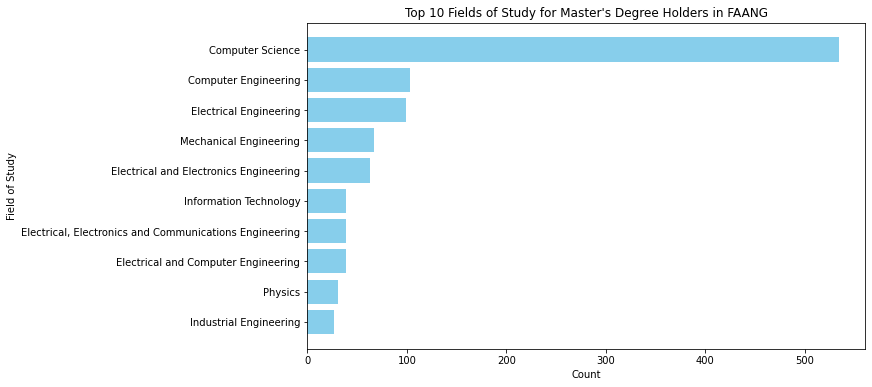

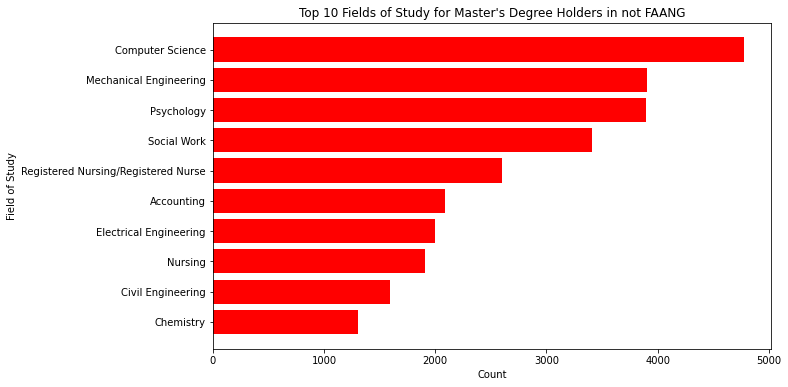

In [0]:
FAANG_names = ["Apple", "Amazon Web Services (AWS)", "Amazon", "Google", "Facebook", "Netflix"]

users_in_big_FAANG = profiles.filter(
    col("current_company.name").isin(FAANG_names)
)
users_not_in_big_FAANG = profiles.filter(
    ~col("current_company.name").isin(FAANG_names)
)

exploded_df_1 = profiles.select("*", explode("education").alias("education_exploded"))

masters_df = exploded_df_1.filter(
    col("education_exploded.degree").like("%M.S.%") |
    col("education_exploded.degree").like("%MS%") |
    col("education_exploded.degree").like("%Master of Science%") |
    col("education_exploded.degree").like("%MSc%")
)
total_masters = masters_df.count()

faang_masters_count = masters_df.filter(
    col("current_company.name").isin(FAANG_names)
).count()

non_faang_masters_count = masters_df.filter(
    ~col("current_company.name").isin(FAANG_names)
).count()

total_count = profiles.count()

FAANG_names = ["Apple", "Amazon Web Services (AWS)", "Amazon", "Google", "Facebook", "Netflix"]

users_in_big_FAANG = profiles.filter(
    col("current_company.name").isin(FAANG_names)
)
users_not_in_big_FAANG = profiles.filter(
    ~col("current_company.name").isin(FAANG_names)
)

exploded_df_1 = profiles.select("*", explode("education").alias("education_exploded"))

masters_df = exploded_df_1.filter(
    col("education_exploded.degree").like("%M.S.%") |
    col("education_exploded.degree").like("%MS%") |
    col("education_exploded.degree").like("%Master of Science%") |
    col("education_exploded.degree").like("%MSc%")
)
total_masters = masters_df.count()

faang_masters_count = masters_df.filter(
    col("current_company.name").isin(FAANG_names)
).count()

non_faang_masters_count = masters_df.filter(
    ~col("current_company.name").isin(FAANG_names)
).count()

total_count = profiles.count()
from pyspark.sql.functions import explode, mean

common_fields_faang_masters = masters_df.filter(
    col("current_company.name").isin(FAANG_names)
).select(
    explode("education.field").alias("field")
).groupBy("field").count().orderBy(desc("count"))

common_fields_faang_masters_no_nulls = common_fields_faang_masters.filter(col("field").isNotNull())
common_fields_faang_masters_pandas = common_fields_faang_masters_no_nulls.toPandas()
common_fields_faang_masters_pandas_sorted = common_fields_faang_masters_pandas.sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(common_fields_faang_masters_pandas_sorted['field'], common_fields_faang_masters_pandas_sorted['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Field of Study')
plt.title('Top 10 Fields of Study for Master\'s Degree Holders in FAANG')
plt.gca().invert_yaxis() 
plt.show()

common_fields_not_faang_masters = masters_df.filter(
    ~col("current_company.name").isin(FAANG_names)
).select(
    explode("education.field").alias("field")
).groupBy("field").count().orderBy(desc("count"))

common_fields_not_faang_masters_no_nulls = common_fields_not_faang_masters.filter(col("field").isNotNull())
common_fields_not_faang_masters_pandas = common_fields_not_faang_masters_no_nulls.toPandas()
common_fields_not_faang_masters_pandas_sorted = common_fields_not_faang_masters_pandas.sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(common_fields_not_faang_masters_pandas_sorted['field'], common_fields_not_faang_masters_pandas_sorted['count'], color='red')
plt.xlabel('Count')
plt.ylabel('Field of Study')
plt.title('Top 10 Fields of Study for Master\'s Degree Holders in not FAANG')
plt.gca().invert_yaxis() 
plt.show()

interesting insights :
The plots reveal that technical fields such as Computer Science and Engineering predominate among Master's degree holders in FAANG companies, reflecting the industry's demand for tech-oriented expertise. In contrast, the diversity of fields is broader in non-FAANG companies, including non-technical disciplines like Psychology and Social Work, suggesting a wider variety of roles and opportunities outside the tech-centric FAANG ecosystem.

# Question 4

### 1)

#####How does working for major companies (such as FAANG) impact the LinkedIn behaviors of their employees ?

why is it intersting : that would highlight industry-specific networking norms and practices, and could provide insights into how professional identity on LinkedIn are shaped by one's workplace.



* This question is backed up by a lot of analysis that we did in question 3

## 2)

##### How does the duration of employment at a company influence an employee's LinkedIn follower count, and what implications does this have on their professional networking capabilities ?
why is it intersting :   


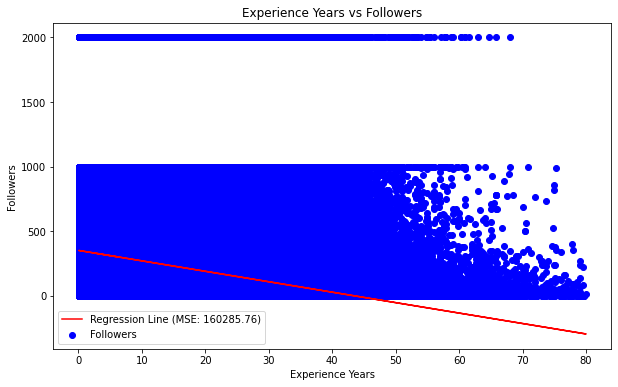

In [0]:
def convert_duration_to_decimal(duration_str):
    try:
        if duration_str is None:
            return None
        parts = duration_str.split()
        years = 0
        months = 0
        if 'years' in duration_str or 'year' in duration_str:
            years = int(parts[0])
        if 'months' in duration_str or 'month' in duration_str:
            months_index = 2 if 'years' in duration_str or 'year' in duration_str else 0
            months = int(parts[months_index])
        return years + months / 12.0
    except ValueError:
       
        print(f"Cannot convert {duration_str} to decimal.")
        return None  
    
convert_duration_to_decimal_udf = udf(convert_duration_to_decimal, FloatType())

exploded_df = profiles.selectExpr("*", "explode(experience) as exp_flat")
exploded_df = exploded_df.withColumn("exp_years", convert_duration_to_decimal_udf("exp_flat.duration_short"))


exploded_df = exploded_df.na.drop(subset=["exp_years"])
exploded_df = exploded_df.na.drop(subset=["followers"])
exploded_df = exploded_df.fillna({'followers': 0})
exploded_df = exploded_df.withColumn("exp_years", col("exp_years").cast("double"))
exploded_df = exploded_df.filter(col("exp_years") <= 80)
count_down = exploded_df.filter(col("exp_years") <= 80).count()
count_up = exploded_df.filter(col("exp_years") >= 80).count()

percentile_95 = exploded_df.select(
    percentile_approx("followers", 0.95).alias("percentile_95")
).collect()[0]["percentile_95"]

df_filtered = exploded_df.filter(col("followers") <= lit(percentile_95))

to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_with_vectors = df_filtered.withColumn("followers_vec", to_vector("followers"))

extract_element = udf(lambda v: float(v[0]), FloatType())
df_normalized = df_with_vectors.withColumn("followers_normalized", extract_element("followers_vec"))

vectorAssembler = VectorAssembler(inputCols=["exp_years"], outputCol="features")
df_features = vectorAssembler.transform(df_normalized)

lr = LinearRegression(featuresCol="features", labelCol="followers_normalized")
lr_model = lr.fit(df_features)
predictions = lr_model.transform(df_features)
evaluator = RegressionEvaluator(labelCol="followers_normalized", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
plot_data = predictions.select("exp_years", "followers_normalized", "prediction").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(plot_data["exp_years"], plot_data["followers_normalized"], color='blue', label='Followers')
plt.plot(plot_data["exp_years"], plot_data["prediction"], color='red', label=f'Regression Line (MSE: {mse:.2f})')
plt.title('Experience Years vs Followers')
plt.xlabel('Experience Years')
plt.ylabel('Followers')
plt.legend()
plt.show()

interesting insights :
- the plot suggests a complex relationship between experience and follower count that is likely influenced by a variety of factors, including networking behavior, professional development stages, and individual engagement strategies on LinkedIn.
- Diminishing Followers with Experience: For profiles with higher experience years, the follower count clusters lower. This might reflect a more established network that grows at a slower rate, or a shift in focus away from network expansion in later career stages.

## 3)

##### How does the geographic location impact the level of education and academic achievement across different states ?

why is it interesting  : it may shed a light on the complex relation between geographic factors and educational outcomes.

In [0]:
def calculate_duration(start_year, end_year):
    if start_year and end_year:
        return int(end_year) - int(start_year)
    else:
        return 0

def extract_state(city):
    parts = city.split(", ")
    if len(parts) == 3:
        return parts[1]  
    else:
        return None  

calculate_duration_udf = udf(calculate_duration, IntegerType())
extract_state_udf = udf(extract_state, StringType())
df_exploded = profiles.withColumn("education", explode("education"))
df_with_duration = df_exploded.withColumn("education_duration", calculate_duration_udf(col("education.start_year"), col("education.end_year")))
df_summed_per_user = df_with_duration.groupBy("id").agg(sum_("education_duration").alias("total_education_duration"))
df_joined = df_summed_per_user.join(profiles, "id")
df_with_state = df_joined.withColumn("state", extract_state_udf(col("city")))
df_mean_education_duration_by_state = df_with_state.groupBy("state").agg(avg("total_education_duration").alias("mean_total_education_duration"))
df_mean_education_duration_by_state_ordered = df_mean_education_duration_by_state.orderBy(col("mean_total_education_duration").desc())

filtered_df = df_mean_education_duration_by_state_ordered.filter(
    (col("state") != "District of Columbia") &
    (col("state").isNotNull()) &
    (col("state") != "United States of America")
)

df = filtered_df.toPandas()

df['state'] = df['state'].map(state_abbreviations)

fig = px.choropleth(df, 
                    locations='state', 
                    locationmode="USA-states", 
                    color='mean_total_education_duration',
                    color_continuous_scale='Blues',
                    scope="usa",
                    title='Education Level by State')

fig.show()